In [23]:
import pandas as pd
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate
import numpy as np

Load MovieLens dataset as an example

In [24]:
movies = pd.read_csv("movies.csv")  # Load movie data (movieId, title, genres)
ratings = pd.read_csv("ratings.csv")  # Load user ratings (userId, movieId, rating)

Step 1: Data Preprocessing (if applicable, depending on the dataset)<br>
Data Processing: Convert genres into binary columns using one-hot encoding<br>
Split the 'genres' column containing pipe-separated genres into binary columns for each genre

In [25]:
genres_list = movies["genres"].str.get_dummies(sep="|")
# Concatenate the binary genre columns back to the 'movies' DataFrame
movies = pd.concat([movies, genres_list], axis=1)

Step 2: Handling Missing Values (if applicable, depending on the dataset)<br>
Handling Missing Values: Fill missing values in the 'rating' column with the mean rating<br>
Calculate the mean rating from the 'rating' column

In [26]:
mean_rating = ratings["rating"].mean()
# Fill the missing values in the 'rating' column with the calculated mean rating
ratings["rating"].fillna(mean_rating, inplace=True)

Collaborative Filtering with Surprise<br>
Step 3: Create a Surprise Reader with the rating scale (minimum and maximum ratings)

In [27]:
reader = Reader(rating_scale=(0.5, 5.0))

Step 4: Load the user ratings data into a Surprise Dataset using the Reader

In [28]:
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)

Step 5: Split the dataset into training and testing sets for evaluation

In [29]:
trainset, testset = train_test_split(data, test_size=0.2)

Step 6: Use SVD (Singular Value Decomposition) for collaborative filtering

In [30]:
svd = SVD()
svd.fit(trainset)

Content-Based Filtering with TF-IDF<br>
Step 7: Create a TF-IDF vectorizer for content-based filtering

In [31]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english")

Step 8: Preprocess the 'genres' column in the 'movies' DataFrame (remove '|' separator)

In [32]:
movies["genres"] = movies["genres"].str.replace("|", " ")

Step 9: Create the TF-IDF matrix for content-based filtering using the 'genres' column

In [33]:
tfidf_matrix = tfidf_vectorizer.fit_transform(movies["genres"])

Step 10: Compute the cosine similarity between TF-IDF vectors for content-based filtering

In [34]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

Deep Learning Model for Neural Collaborative Filtering (NCF)<br>
Step 11: Create a neural collaborative filtering model

In [14]:
def create_ncf_model(num_users, num_movies, latent_dim=128):
    user_input = Input(shape=(1,))
    movie_input = Input(shape=(1,))
    user_embedding = Embedding(input_dim=num_users, output_dim=latent_dim, input_length=1)(user_input)
    movie_embedding = Embedding(input_dim=num_movies, output_dim=latent_dim, input_length=1)(movie_input)
    user_flatten = Flatten()(user_embedding)
    movie_flatten = Flatten()(movie_embedding)
    concat = Concatenate()([user_flatten, movie_flatten])
    dense_1 = Dense(64, activation='relu')(concat)
    dense_2 = Dense(32, activation='relu')(dense_1)
    output = Dense(1)(dense_2)
    model = Model(inputs=[user_input, movie_input], outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

Step 12: Create user and movie index mapping

In [15]:
user_to_idx = {user_id: idx for idx, user_id in enumerate(ratings["userId"].unique())}
movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(ratings["movieId"].unique())}
user_to_idx


{1: 0, 2: 1}

Step 15: Train the model using real data<br>
Map user and movie IDs to their respective indices for training

In [35]:
X_train_user_indices = ratings["userId"].map(user_to_idx)
X_train_movie_indices = ratings["movieId"].map(movie_to_idx)
X_train_movie_indices

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10     0
11     1
12     2
13     3
14     4
15     5
16     6
17     7
18     8
19     9
20    10
21    11
Name: movieId, dtype: int64

Use the same ratings data for the target labels

In [36]:
y_train = ratings["rating"]
y_train


0     5.0
1     3.0
2     4.5
3     4.0
4     4.0
5     1.0
6     4.0
7     1.5
8     1.5
9     5.0
10    1.0
11    2.5
12    3.0
13    2.0
14    2.5
15    4.0
16    3.5
17    4.0
18    4.5
19    4.0
20    1.0
21    4.0
Name: rating, dtype: float64

Create the NCF model

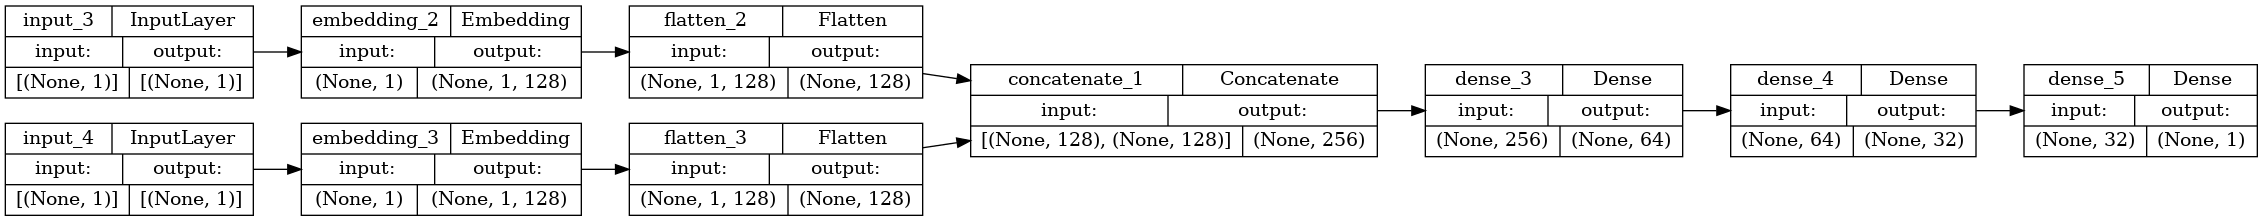

In [37]:

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

ncf_model = create_ncf_model(num_users=len(user_to_idx), num_movies=len(movie_to_idx))
#plot_model(ncf_model, to_file='ncf_model_architecture.png', show_shapes=True, show_layer_names=True)
plot_model(
    ncf_model,
    show_shapes=True,
    show_layer_names=True,
    rankdir='LR',  # Left-to-right layout
    expand_nested=True,  # Expand nested models
    dpi=96,  # Higher resolution for saved image (if any)
    to_file='ncf_model_architecture.png'  # Save the image with the specified filename
)

Train the NCF model using user and movie indices

In [38]:
ncf_model.fit([X_train_user_indices, X_train_movie_indices], y_train, epochs=200, batch_size=64)

Epoch 1/200


1/1 [==============================] - 1s 889ms/step - loss: 11.7095
Epoch 2/200
1/1 [==============================] - 0s 7ms/step - loss: 11.4805
Epoch 3/200
1/1 [==============================] - 0s 7ms/step - loss: 11.2733
Epoch 4/200
1/1 [==============================] - 0s 6ms/step - loss: 11.0851
Epoch 5/200
1/1 [==============================] - 0s 7ms/step - loss: 10.9081
Epoch 6/200
1/1 [==============================] - 0s 7ms/step - loss: 10.7219
Epoch 7/200
1/1 [==============================] - 0s 7ms/step - loss: 10.5248
Epoch 8/200
1/1 [==============================] - 0s 7ms/step - loss: 10.3139
Epoch 9/200
1/1 [==============================] - 0s 6ms/step - loss: 10.0873
Epoch 10/200
1/1 [==============================] - 0s 6ms/step - loss: 9.8466
Epoch 11/200
1/1 [==============================] - 0s 6ms/step - loss: 9.5882
Epoch 12/200
1/1 [==============================] - 0s 5ms/step - loss: 9.3113
Epoch 13/200
1/1 [==============================] - 0s 6ms/ste

Modified Optimized Recommendation Function to use NCF Model

In [39]:
def get_recommendations(user_id, num_recommendations=3):
    # Collaborative Filtering with NCF
    # Get the movies watched by the user with 'user_id' from the 'ratings' DataFrame
    user_movies = ratings[ratings["userId"] == user_id]["movieId"]
    # Convert user and movie IDs to their respective indices for NCF model
    user_idx = user_to_idx[user_id]
    movie_indices = [movie_to_idx[movie_id] for movie_id in user_movies]

    # Predict ratings for the user and unrated movies using the NCF model
    user_ratings = [ncf_model.predict([[user_idx], [movie_idx]])[0][0] for movie_idx in range(len(movie_to_idx))]
    unrated_movies = [movie_idx for movie_idx in range(len(movie_to_idx)) if movie_idx not in movie_indices]

    # Combine Collaborative and Content-Based Recommendations (same as before)
    collab_recommendations = [
        (movieId, svd.predict(user_id, movieId).est)
        for movieId in movies["movieId"]
        if movieId not in user_movies
    ]
    collab_recommendations.sort(key=lambda x: x[1], reverse=True)
    movie_indices = [
        movies[movies["movieId"] == movie_id].index[0] for movie_id in user_movies
    ]
    similar_movies = list(enumerate(cosine_sim[movie_indices[-1]]))
    content_predictions = [
        (movies.iloc[i]["movieId"], score)
        for i, score in similar_movies
        if i not in movie_indices
    ]
    content_predictions.sort(key=lambda x: x[1], reverse=True)

    # Combine collaborative and content-based recommendations, giving priority to collaborative filtering
    hybrid_recommendations = (
        collab_recommendations[:num_recommendations]
        + content_predictions[:num_recommendations]
    )
    hybrid_recommendations.sort(key=lambda x: x[1], reverse=True)

    # Return the movieIds of the top 'num_recommendations' hybrid recommendations
    return [movie_id for movie_id, _ in hybrid_recommendations][:num_recommendations]



In [40]:
user_id = 2

user_to_idx[user_id]

1

Example Usage:

In [41]:
user_id = 2  # Replace with the user ID for whom you want
recommendations = get_recommendations(user_id)
print("Top Recommendations for User", user_id)
print(recommendations)

ValueError: in user code:

    File "/home/erfan/Documents/Projects/o3/recom_system/dev/.env/lib/python3.10/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/home/erfan/Documents/Projects/o3/recom_system/dev/.env/lib/python3.10/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/erfan/Documents/Projects/o3/recom_system/dev/.env/lib/python3.10/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/home/erfan/Documents/Projects/o3/recom_system/dev/.env/lib/python3.10/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/home/erfan/Documents/Projects/o3/recom_system/dev/.env/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/erfan/Documents/Projects/o3/recom_system/dev/.env/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_1" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 1) dtype=int64>]
